<a href="https://colab.research.google.com/github/victorhss21/CSV_to_PARQUET/blob/main/tbl_sintetica_haka_claude_v3_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## [!] Gera dados sintéticos

### Gera dados para 202411

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

# Configurar semente para reprodutibilidade
np.random.seed(42)

# Número de registros a gerar
n_registros = 63820

# Gerar as colunas de dados
# Coluna anomes (todos os registros terão a mesma data)
anomes = pd.to_datetime(['2024-11-01'] * n_registros)

# Gerar num_cpf_cnpj com distribuição aproximada
# Usando estatísticas fornecidas para gerar valores aproximados
num_cpf_cnpj = np.random.randint(633, 98597918, size=n_registros)

# Gerar segmentos baseado na amostra
segmentos = ['Servicos', 'Comercio', 'Manufatura', 'Transporte & Logistica', 'Auto',
             'Educacao', 'Alimentacao', 'NN']
# Distribuição aproximada baseada na amostra
segmento_weights = [0.22, 0.26, 0.1, 0.18, 0.08, 0.02, 0.02, 0.12]
segmento = np.random.choice(segmentos, size=n_registros, p=segmento_weights)

# Personas (na amostra todos são TOP)
personas = ['TOP'] * n_registros

# Gerar volume de cash in seguindo a distribuição aproximada
# Usando uma distribuição lognormal para simular os valores de cash in
mu = np.log(4380566.49)  # média do log (baseada na média fornecida)
sigma = 1.5  # desvio padrão estimado para obter a dispersão observada
vol_cash_in_total_m0_3m = np.random.lognormal(mu, sigma, n_registros)
# Ajustar para alguns valores serem zero (como na amostra)
zero_indices = np.random.choice(n_registros, size=int(0.05 * n_registros), replace=False)
vol_cash_in_total_m0_3m[zero_indices] = 0.0

# Gerar volume de cash in após 3 meses com correlação com o valor atual
correlation = 0.85  # correlação estimada
noise = np.random.lognormal(mu, sigma, n_registros)
vol_cash_in_total_m3_3m = vol_cash_in_total_m0_3m * correlation + noise * (1 - correlation)
# Ajustar para alguns valores serem zero (como na amostra)
zero_indices_m3 = np.random.choice(n_registros, size=int(0.08 * n_registros), replace=False)
vol_cash_in_total_m3_3m[zero_indices_m3] = 0.0

# Gerar status_gs com distribuição aproximada
gs_values = [0, 1, 2, 3, 4, 5, 6, 7]
gs_weights = [0.05, 0.55, 0.2, 0.1, 0.05, 0.02, 0.02, 0.01]  # distribuição aproximada
status_gs_m0_3m = np.random.choice(gs_values, size=n_registros, p=gs_weights)

# Status GS após 3 meses (com alguma correlação com o status atual)
gs_transition = np.random.choice([-1, 0, 1], size=n_registros, p=[0.1, 0.8, 0.1])
status_gs_m3_3m = np.clip(status_gs_m0_3m + gs_transition, 0, 7)
# Definir como 0 para casos onde vol_cash_in_total_m3_3m é 0
status_gs_m3_3m[vol_cash_in_total_m3_3m == 0] = 0

# Gerar tempo de vida em meses com distribuição aproximada
# Usando uma distribuição lognormal para simular a idade das empresas
mu_age = np.log(197.71)  # média do log da idade
sigma_age = 0.8  # desvio padrão estimado
tempo_de_vida_meses = np.random.lognormal(mu_age, sigma_age, n_registros).astype(int)
# Garantir que está dentro dos limites
tempo_de_vida_meses = np.clip(tempo_de_vida_meses, 0, 1433)

# Gerar flag_recem_fundado (4% são recém fundados)
flag_recem_fundado = np.zeros(n_registros, dtype=int)
# Empresas com menos de 6 meses têm maior probabilidade de serem recém fundadas
recent_indices = np.where(tempo_de_vida_meses <= 6)[0]
num_recent = int(0.04 * n_registros)  # total de recém fundados (4%)
if len(recent_indices) >= num_recent:
    flag_recem_fundado[np.random.choice(recent_indices, num_recent, replace=False)] = 1
else:
    flag_recem_fundado[recent_indices] = 1
    remaining = num_recent - len(recent_indices)
    other_indices = np.where(tempo_de_vida_meses > 6)[0]
    flag_recem_fundado[np.random.choice(other_indices, remaining, replace=False)] = 1

# Status receita federal (100% ativos na amostra)
status_receita_federal = ['ATIVO'] * n_registros

# Flag inapto/suspenso/baixado (0% na amostra)
flag_inapto_suspenso_baixado = np.zeros(n_registros, dtype=int)

# Flag inativo (0% na amostra)
flag_inativo = np.zeros(n_registros, dtype=int)

# Criar o DataFrame
df_sintetico = pd.DataFrame({
    'anomes': anomes,
    'num_cpf_cnpj': num_cpf_cnpj,
    'segmento': pd.Categorical(segmento),
    'personas': pd.Categorical(personas),
    'vol_cash_in_total_m0_3m': vol_cash_in_total_m0_3m,
    'vol_cash_in_total_m3_3m': vol_cash_in_total_m3_3m,
    'status_gs_m0_3m': status_gs_m0_3m,
    'status_gs_m3_3m': status_gs_m3_3m,
    'tempo_de_vida_meses': tempo_de_vida_meses,
    'flag_recem_fundado': flag_recem_fundado,
    'status_receita_federal': pd.Categorical(status_receita_federal),
    'flag_inapto_suspenso_baixado': flag_inapto_suspenso_baixado,
    'flag_inativo': flag_inativo
})

# Arredondar valores monetários para 2 casas decimais
df_sintetico['vol_cash_in_total_m0_3m'] = df_sintetico['vol_cash_in_total_m0_3m'].round(2)
df_sintetico['vol_cash_in_total_m3_3m'] = df_sintetico['vol_cash_in_total_m3_3m'].round(2)

# # Verificar estatísticas do conjunto gerado
# print(df_sintetico.describe())

# # Primeiros registros para verificação
# print(df_sintetico.head(50))

# Informação da estrutura do DataFrame
print(df_sintetico.info())

# Retornar o DataFrame
df_train = df_sintetico

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63820 entries, 0 to 63819
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   anomes                        63820 non-null  datetime64[ns]
 1   num_cpf_cnpj                  63820 non-null  int64         
 2   segmento                      63820 non-null  category      
 3   personas                      63820 non-null  category      
 4   vol_cash_in_total_m0_3m       63820 non-null  float64       
 5   vol_cash_in_total_m3_3m       63820 non-null  float64       
 6   status_gs_m0_3m               63820 non-null  int64         
 7   status_gs_m3_3m               63820 non-null  int64         
 8   tempo_de_vida_meses           63820 non-null  int64         
 9   flag_recem_fundado            63820 non-null  int64         
 10  status_receita_federal        63820 non-null  category      
 11  flag_inapto_suspenso_baixado

### Gera dados para 202412

In [2]:
import numpy as np
import pandas as pd

def generate_synthetic_next_month_data(df: pd.DataFrame,
                                       next_date: str = "2024-12-01",
                                       shift_factor: float = 0.1,
                                       random_state: int = 42) -> pd.DataFrame:
    """
    Gera dados sintéticos para o próximo mês (por padrão, 2024-12-01) a partir de um DataFrame base.

    Parâmetros:
    -----------
    df : pd.DataFrame
        DataFrame original (mês atual), ex.: 2024-11-01
    next_date : str
        Data (YYYY-MM-DD) para atribuir na coluna 'anomes' no novo DataFrame
    shift_factor : float
        Fator de variação aleatória (± shift_factor). Ex.: 0.1 => ±10%
    random_state : int
        Semente de aleatoriedade para reprodutibilidade

    Retorna:
    --------
    df_next : pd.DataFrame
        Novo DataFrame com valores sintéticos para o mês subsequente
    """

    rng = np.random.default_rng(random_state)

    # 1. Copia o DataFrame original
    df_next = df.copy(deep=True)

    # 2. Atualiza a coluna de data para o novo mês
    if 'anomes' in df_next.columns:
        df_next['anomes'] = pd.to_datetime(next_date)

    # 3. Define um helper para gerar variação aleatória multiplicativa
    #    Ex.: se shift_factor = 0.1 => variação entre 0.9 e 1.1
    def random_variation(size):
        return rng.uniform(1 - shift_factor, 1 + shift_factor, size=size)

    # 4. Para colunas numéricas de M0 e M3 (ex.: vol_cash_in_total_m0_3m / vol_cash_in_total_m3_3m),
    #    podemos simular a "passagem do tempo" da seguinte forma:
    #    - O novo M0 passa a ser o antigo M3
    #    - O novo M3 é o antigo M3 * (1 ± fator aleatório)
    #    Ajuste conforme o comportamento que deseja simular.

    for col in df_next.columns:
        if col.endswith('_m0_3m'):
            # Base do nome (ex.: "vol_cash_in_total")
            base = col[:-6]
            col_m3 = base + '_m3_3m'

            # Garante que a coluna _m3_3m existe antes de acessar
            if col_m3 in df_next.columns:
                # Novo M0 = antigo M3
                df_next[col] = df[col_m3].values

        elif col.endswith('_m3_3m'):
            # Aplica um fator aleatório sobre o antigo M3
            old_values = df_next[col].values
            factors = random_variation(len(df_next))  # array de multiplicadores
            df_next[col] = old_values * factors

    # 5. Se houver colunas de status_gs_m0_3m / status_gs_m3_3m,
    #    podemos simular incrementos/decrementos inteiros.
    if 'status_gs_m0_3m' in df_next.columns and 'status_gs_m3_3m' in df_next.columns:
        # Exemplo: Novo M0 = antigo M3
        df_next['status_gs_m0_3m'] = df_next['status_gs_m3_3m']

        # Novo M3 = antigo M3 + um valor aleatório de -1 a +1 (limitando a faixa [0..7] se status_gs vai até 7)
        shift_random = rng.integers(-1, 2, size=len(df_next))  # valores -1, 0, 1
        new_m3 = df_next['status_gs_m3_3m'] + shift_random
        # Garante que não saia do range [0..7] (ajuste conforme sua lógica)
        new_m3 = np.clip(new_m3, 0, 7)
        df_next['status_gs_m3_3m'] = new_m3

    return df_next


# Exemplo de uso:
df_nov = df_train  # DataFrame do mês 2024-11-01
df_dec = generate_synthetic_next_month_data(df_nov, next_date="2024-12-01", shift_factor=0.1)

# Visualiza amostra de dados
df_dec.head()


,anomes,num_cpf_cnpj,segmento,personas,vol_cash_in_total_m0_3m,vol_cash_in_total_m3_3m,status_gs_m0_3m,status_gs_m3_3m,tempo_de_vida_meses,flag_recem_fundado,status_receita_federal,flag_inapto_suspenso_baixado,flag_inativo
0,2024-12-01,65683500,Auto,TOP,0.00,0.000000e+00,0.000000,0.000000,84,0,ATIVO,0,0
1,2024-12-01,56755669,Auto,TOP,3934498.45,3.886402e+06,3.194174,3.194174,184,0,ATIVO,0,0
2,2024-12-01,56882915,Comercio,TOP,15049821.23,1.612919e+07,2.122061,3.122061,98,0,ATIVO,0,0
3,2024-12-01,21082421,Comercio,TOP,6904429.57,7.176972e+06,1.050979,2.050979,161,0,ATIVO,0,0
4,2024-12-01,13315725,Manufatura,TOP,19254826.04,1.769202e+07,1.056014,0.056014,592,0,ATIVO,0,0


In [3]:
# Exportando bases para Parquet
df_dec.to_parquet('df_classificados_202412.parquet', engine='pyarrow', compression='snappy')
print(f"DataFrame 'df_dec' exportado como Parquet")

DataFrame 'df_dec' exportado como Parquet


## 05. Classificação Analítica (Heurística)



> Aplicação de regras definidas em grupos, após a consolidação de várias experiências de negócios. O objetivo é classificar o momento de vida com base em 3 principais variáveis que apresentem evidências factuais do momento de vida: Cash-In, Faturamento Eleito e Status G.

Tendo em vista que ainda temos muitas variáveis, iremos priorizar algumas variáves: Cash-In, Gs, tempo de vida e status da receita federal, selecinando apenas elas.

*(posteriormente, o objetivo é identificar a importância das demais features com um modelo de árvore, por exemplo)*

In [4]:
# Especificação das variáveis que serão avaliadas
df = df_train[['anomes','num_cpf_cnpj','segmento','personas','vol_cash_in_total_m0_3m','vol_cash_in_total_m3_3m',
      'status_gs_m0_3m','status_gs_m3_3m','tempo_de_vida_meses','flag_recem_fundado','status_receita_federal',
      'flag_inapto_suspenso_baixado','flag_inativo']].copy()

*(Daremos poder maior de decisão ao Cash-In, visto que é uma informação aferida, mais tempestiva e, idealmente, deveria ter uma forte correlação com o Faturamento da empresa)*

In [5]:
import numpy as np
import pandas as pd

def process_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Processa o DataFrame aplicando as regras descritas:
      - Agrupa os registros por 'segmento' e 'personas'
      - Para cada variável numérica decimal (com sufixos _m0_3m e _m3_3m, exceto status_gs),
        calcula delta = (m0 / m3) - 1 (com tratamento para m3=0 e infinitos).
      - Calcula percentis (20, 40, 50, 60, 80) por grupo para cada delta e gera novas colunas p<xx>_delta_<var>.
      - Cria colunas status_delta_<variavel> usando a lógica:
         1) Se todas as observações do grupo são < 0, todas são "declinio"
         2) Se todas são >= 0, usa p60 para separar "estavel" (delta < p60) de "crescimento" (delta >= p60)
         3) Caso contrário, usa p40/p60 para separar declinio/estavel/crescimento
      - Cria colunas intensidade_delta_<variavel> (forte/moderado) com base nos percentis 20 e 80.
      - Para status_gs, calcula delta_status_gs = (status_gs_m0_3m - status_gs_m3_3m).
         • "saudavel" se > 0
         • "nao_saudavel" caso contrário
      - Cria status_momento_empresa considerando flags (inativo > inapto_suspenso_baixado > recem_fundado),
        caso nenhum flag esteja ativo, concatena status_delta_vol_cash_in_total, status_delta_status_gs e
        intensidade_delta_vol_cash_in_total (tudo em minúsculo).
      - (Opcional) Remove valores negativos e infinitos dos campos delta_<variavel> no DataFrame final.
    """

    # 1. Identifica variáveis numéricas com sufixo _m0_3m e _m3_3m,
    #    EXCETO se forem referentes a status_gs (tratado em separado).
    numeric_vars = []
    for col in df.columns:
        if col.endswith('_m0_3m'):
            base = col[:-6]  # remove "_m0_3m"
            if base + '_m3_3m' in df.columns and not base.startswith('status_gs'):
                numeric_vars.append(base)

    # 2. Calcula a coluna delta para cada var numérica decimal (similar a cash_in)
    for var in numeric_vars:
        m0 = df[f'{var}_m0_3m']
        m3 = df[f'{var}_m3_3m']

        # Evita divisão por zero => se m3 == 0, delta = 0
        ratio = np.where(m3 == 0, 0, m0 / m3) - 1

        # Substitui ±inf ou NaN por 0
        ratio = np.where(np.isinf(ratio) | np.isnan(ratio), 0, ratio)

        df[f'delta_{var}'] = ratio

    # 3. Define agrupamentos e percentis
    group_keys = ['segmento', 'personas']
    percentis = [20, 40, 50, 60, 80]

    # Calcula os percentis p<xx>_delta_<var> por grupo
    for var in numeric_vars:
        delta_var = f'delta_{var}'
        for p in percentis:
            col_name = f'p{p}_{delta_var}'
            df[col_name] = df.groupby(group_keys, observed=False)[delta_var].transform(
                lambda x: np.percentile(x, p)
            )

    # Função de classificação para qualquer variável decimal (era a lógica especial de cash_in)
    def status_delta_decimal(x, p40, p60):
        """
        1) Se todas < 0 => "declinio"
        2) Se todas >= 0 => delta < p60 => "estavel", delta >= p60 => "crescimento"
        3) Caso misto => delta > p60 => "crescimento", delta < p40 => "declinio", senão => "estavel"
        """
        if (x < 0).all():
            return np.array(["declinio"] * len(x))
        elif (x >= 0).all():
            return np.where(x < p60, "estavel", "crescimento")
        else:
            return np.where(
                x > p60, "crescimento",
                np.where(x < p40, "declinio", "estavel")
            )

    # 4. Cria colunas status_delta_<variavel> para cada var decimal
    for var in numeric_vars:
        delta_var = f'delta_{var}'
        status_col = f'status_delta_{var}'

        def assign_status(series):
            p60_val = np.percentile(series, 60)
            p40_val = np.percentile(series, 40)
            return status_delta_decimal(series, p40_val, p60_val)

        df[status_col] = df.groupby(group_keys, observed=False)[delta_var].transform(assign_status)

    # 5. Cria as colunas intensidade_delta_<variavel> (forte ou moderado)
    for var in numeric_vars:
        delta_var = f'delta_{var}'
        intensidade_col = f'intensidade_delta_{var}'

        def assign_intensidade(x):
            p80 = np.percentile(x, 80)
            p20 = np.percentile(x, 20)
            return np.where((x > p80) | (x < p20), "forte", "moderado")

        df[intensidade_col] = df.groupby(group_keys, observed=False)[delta_var].transform(assign_intensidade)

    # 6. Regra especial para status_gs: delta_status_gs = (M0 - M3)
    if 'status_gs_m0_3m' in df.columns and 'status_gs_m3_3m' in df.columns:
        df['delta_status_gs'] = df['status_gs_m0_3m'] - df['status_gs_m3_3m']
        df['status_delta_status_gs'] = np.where(
            df['delta_status_gs'] > 0,
            "saudavel",
            "nao_saudavel"
        )

    # 7. Cria status_momento_empresa com prioridade de flags
    def determine_status(row):
        if row.get('flag_inativo', 0) == 1:
            return "inativa"
        elif row.get('flag_inapto_suspenso_baixado', 0) == 1:
            return "inapta_suspensa_baixada"
        elif row.get('flag_recem_fundado', 0) == 1:
            return "recem_fundada"
        else:
            # Exemplo: unimos os status da var vol_cash_in_total e status_gs
            status_cash = row.get('status_delta_vol_cash_in_total', '')
            status_gs = row.get('status_delta_status_gs', '')
            intensidade_cash = row.get('intensidade_delta_vol_cash_in_total', '')
            return f"{status_cash}_{status_gs}_{intensidade_cash}"

    df['status_momento_empresa'] = df.apply(determine_status, axis=1).str.lower()

    # 8. (OPCIONAL) Se for necessário remover valores negativos dos delta_<variavel> no DataFrame final:
    #    Basta "clamp" (clip) para zero.
    for var in numeric_vars:
        delta_var = f'delta_{var}'
        # Substitui ±inf e NaN por 0
        df[delta_var] = df[delta_var].replace([np.inf, -np.inf], np.nan).fillna(0)
        # Se desejar remover valores negativos do resultado final:
        # df[delta_var] = df[delta_var].clip(lower=0)

    return df

In [6]:
# Gera dataframe com classificação dos CNPJs
df_classicados = process_data(df)

In [7]:
# Exportando bases para Parquet
df_classicados.to_parquet('df_classicados.parquet', engine='pyarrow', compression='snappy')
print(f"DataFrame 'df_classicados' exportado como Parquet")

DataFrame 'df_classicados' exportado como Parquet


## 06. Treinamento do Classificador ML

> Treinamento de algoritimos de classificação, visando identificar a importância de outras variáveis, bem como utilizar o modelo para classificação dos dados de validação

In [8]:
# Join dde df_train com df_classificados (para obtenção de target)
df = df_train.merge(df_classicados[['anomes', 'num_cpf_cnpj', 'status_momento_empresa']], on=['anomes', 'num_cpf_cnpj'], how='left')

In [9]:
# Converter múltiplas colunas
df = df.astype({
                'status_gs_m0_3m': 'category',
                'status_gs_m3_3m': 'category',
                'status_momento_empresa': 'category'
            })

df.drop(columns=['status_receita_federal'], inplace=True)

In [10]:
# Visualizando dados para treinamento
df.head(3)

,anomes,num_cpf_cnpj,segmento,personas,vol_cash_in_total_m0_3m,vol_cash_in_total_m3_3m,status_gs_m0_3m,status_gs_m3_3m,tempo_de_vida_meses,flag_recem_fundado,flag_inapto_suspenso_baixado,flag_inativo,status_momento_empresa
0,2024-11-01,65683500,Auto,TOP,734317.43,0.00,1,0,84,0,0,0,declinio_saudavel_forte
1,2024-11-01,56755669,Auto,TOP,648485.55,3934498.45,3,3,184,0,0,0,declinio_nao_saudavel_forte
2,2024-11-01,56882915,Comercio,TOP,11024543.97,15049821.23,3,2,98,0,0,0,declinio_saudavel_moderado


In [11]:
df.to_excel('df_classificados.xlsx', index=False)

### Abordagem 0: Cross Validation com PyCaret

In [12]:
# Instalar PyCaret
!pip install pycaret -q

In [32]:
from pycaret.classification import *
import pandas as pd
import numpy as np

# Remoção segura das colunas
df_model = df.drop(columns=['anomes', 'num_cpf_cnpj'])

# Identificação automática de tipos de features
numeric_features = df_model.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = df_model.select_dtypes(include=['category', 'object']).columns.tolist()

# Garantir que o target não está nas features
categorical_features = [col for col in categorical_features if col != 'status_momento_empresa']

# Configuração do ambiente com tratamento adequado
clf = setup(
    data = df_model,
    target = 'status_momento_empresa',
    train_size = 0.8,
    normalize = True,
    normalize_method = 'minmax',
    categorical_features = categorical_features,
    numeric_features = numeric_features,
    # handle_unknown_categorical = True,  # Essencial para novas categorias
    # fold_stratification = True,         # Importante para classes desbalanceadas
    session_id = 42,
    verbose = False
)

# Comparação de modelos
best_model = compare_models(
    n_select = 1,
    sort = 'Accuracy',
    fold = 5
)

# Modelo final e avaliação
final_model = finalize_model(best_model)
predictions = predict_model(final_model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.9248,0.9940,0.9248,0.9251,0.9245,0.9122,0.9124,8.0840
dt,Decision Tree Classifier,0.8788,0.9301,0.8788,0.8788,0.8787,0.8586,0.8586,1.3400
lightgbm,Light Gradient Boosting Machine,0.8198,0.9052,0.8198,0.8365,0.8247,0.7911,0.7923,16.7740
gbc,Gradient Boosting Classifier,0.8054,0.0000,0.8054,0.8051,0.8047,0.7725,0.7726,96.8220
rf,Random Forest Classifier,0.7460,0.9517,0.7460,0.7465,0.7460,0.7036,0.7036,9.3200
et,Extra Trees Classifier,0.6938,0.9294,0.6938,0.6941,0.6938,0.6426,0.6427,10.8820
lda,Linear Discriminant Analysis,0.4132,0.0000,0.4132,0.4224,0.3910,0.3054,0.3112,0.8060
ridge,Ridge Classifier,0.3968,0.0000,0.3968,0.3666,0.3484,0.2845,0.2966,0.7360
lr,Logistic Regression,0.3936,0.0000,0.3936,0.3767,0.3562,0.2846,0.2971,7.0560
knn,K Neighbors Classifier,0.3832,0.7319,0.3832,0.3723,0.3748,0.2780,0.2787,6.9860


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.9225,0.9931,0.9225,0.9260,0.9219,0.9096,0.9104


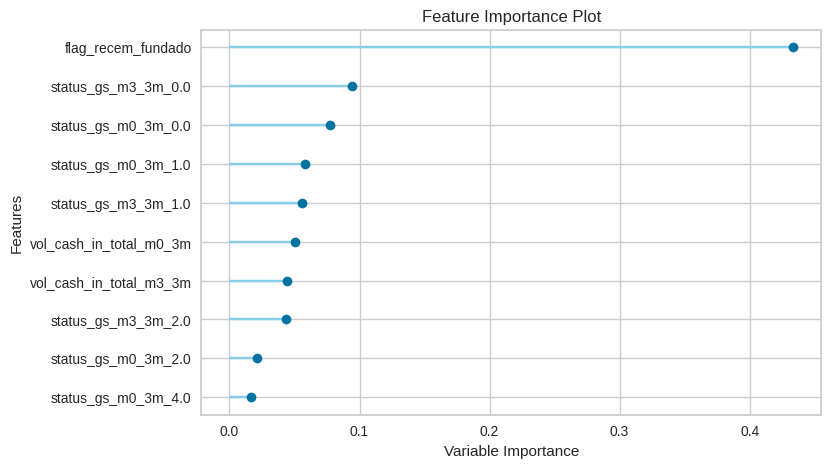

In [33]:
# Exibindo feature importance do modelo
plot_model(final_model, plot='feature')

In [35]:
# Outras métricas de avaliação
evaluate_model(final_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

### Abordagem 1: Cross Validation

In [51]:
# Import das libs
import pandas as pd
import numpy as np
from io import StringIO
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Supondo que o DataFrame já foi processado e possui a coluna target "status_momento_empresa"
# Removemos as colunas que não serão usadas como features.
features_to_drop = ['anomes', 'num_cpf_cnpj', 'status_momento_empresa']
X = df.drop(columns=features_to_drop)
y = df['status_momento_empresa']

# Seleciona features numéricas e categóricas (incluindo dtype 'category')
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)

# Crie pipelines separados para pré-processar os dados numéricos e categóricos.
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine as transformações usando ColumnTransformer.
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# Crie a pipeline final com o pré-processamento e o RandomForestClassifier.
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Validação cruzada com 5 folds usando StratifiedKFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(pipeline, X, y, cv=cv)
print("CV accuracy scores:", scores)
print("Mean CV accuracy:", scores.mean())

# Ajuste o pipeline no conjunto completo para extrair as feature importances.
pipeline.fit(X, y)

# Extraia os nomes das features transformadas:
# 1. As numéricas permanecem com os mesmos nomes.
# 2. As categóricas são transformadas pelo OneHotEncoder.
onehot = pipeline.named_steps['preprocessor'].named_transformers_['cat']
cat_feature_names = list(onehot.get_feature_names_out(categorical_features))
all_feature_names = numeric_features + cat_feature_names

Numeric features: ['vol_cash_in_total_m0_3m', 'vol_cash_in_total_m3_3m', 'tempo_de_vida_meses', 'flag_recem_fundado', 'flag_inapto_suspenso_baixado', 'flag_inativo']
Categorical features: ['segmento', 'personas', 'status_gs_m0_3m', 'status_gs_m3_3m']
CV accuracy scores: [0.75812133 0.76320939 0.76172211 0.76555773 0.75129169]
Mean CV accuracy: 0.7599804507504695


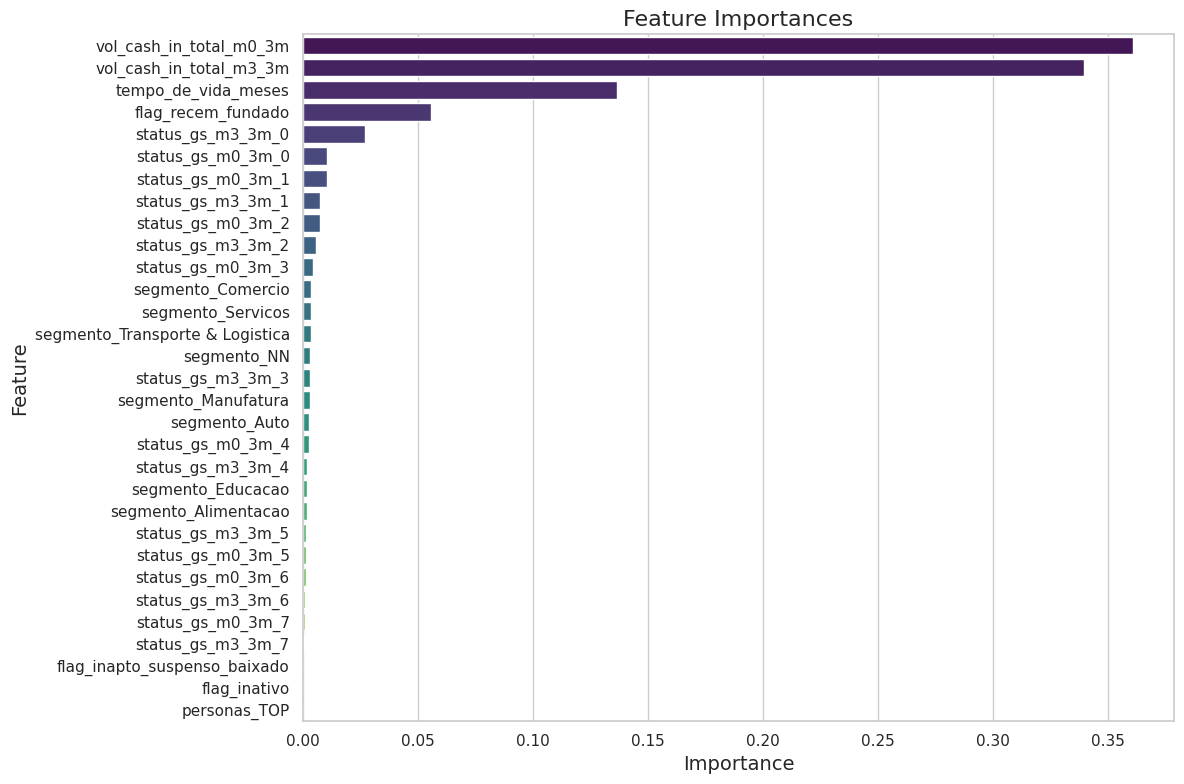

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extração das feature importances do RandomForestClassifier
importances = pipeline.named_steps['classifier'].feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': all_feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# print("Feature Importances:")
# print(feature_importance_df)

# Configura o estilo do Seaborn
sns.set(style="whitegrid")

# Cria o gráfico de barras horizontais
plt.figure(figsize=(12, 8))
sns.barplot(x="importance", y="feature", data=feature_importance_df, palette="viridis", hue="feature", orient="h")

# Configurações adicionais
plt.title("Feature Importances", fontsize=16)
plt.xlabel("Importance", fontsize=14)
plt.ylabel("Feature", fontsize=14)
plt.tight_layout()
plt.show();

### Abordagem 2: Hold-out validation

> Tempo de execução: 15min

In [35]:
import pandas as pd
import numpy as np
from io import StringIO
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Removendo colunas que não serão usadas como features
features_to_drop = ['anomes', 'num_cpf_cnpj', 'status_momento_empresa']
X = df.drop(columns=features_to_drop)
y = df['status_momento_empresa']

# Seleciona as features numéricas e categóricas com base no tipo de dado
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=['category']).columns.tolist()

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)

# Criação dos pipelines para pré-processamento
numeric_transformer = Pipeline(steps=[
    # ('scaler', StandardScaler())
    ('scaler', MinMaxScaler())

])
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# Criação do pipeline final com RandomForestClassifier
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Split treino/teste: 80% treino e 20% teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Ajusta o modelo no conjunto de treino
pipeline.fit(X_train, y_train)

# Avalia no conjunto de teste
y_pred = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Test accuracy:", accuracy)

# Extração dos nomes das features transformadas:
# 1. As features numéricas mantêm seus nomes.
# 2. As categóricas são transformadas pelo OneHotEncoder.
onehot = pipeline.named_steps['preprocessor'].named_transformers_['cat']
cat_feature_names = list(onehot.get_feature_names_out(categorical_features))
all_feature_names = numeric_features + cat_feature_names

Numeric features: ['vol_cash_in_total_m0_3m', 'vol_cash_in_total_m3_3m', 'tempo_de_vida_meses', 'flag_recem_fundado', 'flag_inapto_suspenso_baixado', 'flag_inativo']
Categorical features: ['segmento', 'personas', 'status_gs_m0_3m', 'status_gs_m3_3m']
Test accuracy: 0.7629745596868884


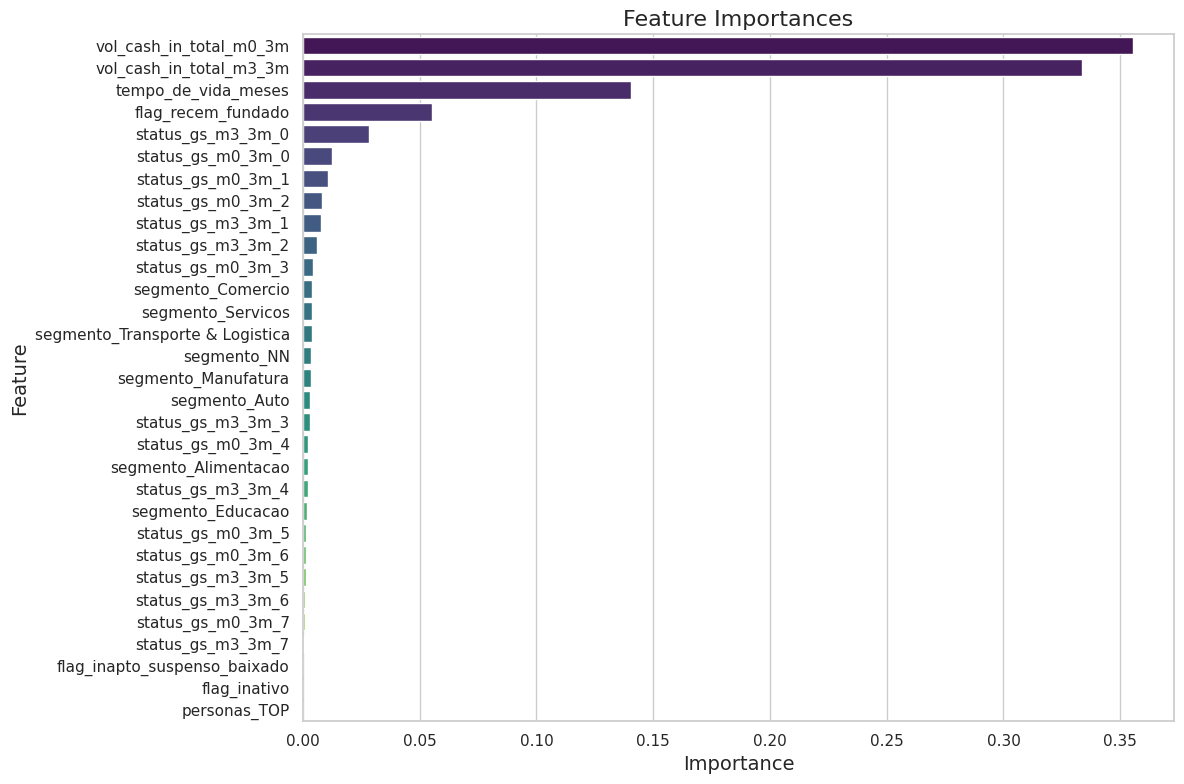

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extração das feature importances do RandomForestClassifier
importances = pipeline.named_steps['classifier'].feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': all_feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# print("Feature Importances:")
# print(feature_importance_df)

# Configura o estilo do Seaborn
sns.set(style="whitegrid")

# Cria o gráfico de barras horizontais
plt.figure(figsize=(12, 8))
sns.barplot(x="importance", y="feature", data=feature_importance_df, palette="viridis", hue="feature", orient="h")

# Configurações adicionais
plt.title("Feature Importances", fontsize=16)
plt.xlabel("Importance", fontsize=14)
plt.ylabel("Feature", fontsize=14)
plt.tight_layout()
plt.show();

## 07. "Validação" do Classificador Analítico

> Dado que não temos os rotulos reais para os CNPJs, nossa ideia de validação é avaliar a consistência do modelo heurístico. Isto é, avaliar instabilidade da classificação por parte do modelo, avaliando a marcação feita em 202411 e 202412 para o mesmo CNPJ.
>
> No fim, o ojetivo é encontrar o menor número de classificação adversas MoM, considerando um mesmo CNPJ (ex: não queremos que um CNPJ Marcado com "crescimento saúdável intenso" seja marcado como "inativo" ou "declinio não saudável intenso")

### 7.1 Adequação dos dados

In [78]:
# Carrega conjunto df_classificados_202412
df = pd.read_parquet('df_classificados_202412.parquet')

# Aplica classificador heurístico nos CNPJs da ref. 202412
df_classificados_202412 = process_data(df)

In [83]:
# Carrega conjunto df_classificados_202412
df_classificados_202412 = df_classificados_202412[['anomes', 'num_cpf_cnpj', 'segmento', 'personas',
                                                  'vol_cash_in_total_m0_3m', 'vol_cash_in_total_m3_3m', 'status_gs_m0_3m',
                                                  'status_gs_m3_3m', 'status_receita_federal', 'status_momento_empresa']].copy()

# Cria dataframe df_classificados_202411 usando df_classicados
df_classificados_202411 = df_classicados[['anomes', 'num_cpf_cnpj', 'segmento', 'personas',
                                          'vol_cash_in_total_m0_3m', 'vol_cash_in_total_m3_3m', 'status_gs_m0_3m',
                                          'status_gs_m3_3m', 'status_receita_federal', 'status_momento_empresa']].copy()

In [146]:
# Realize left join de df_classificados_202412 e df_classificados_202411 pela chave num_cpf_cnpj (para análises)
df_merged = df_classificados_202412.merge(df_classificados_202411, on='num_cpf_cnpj', how='left', suffixes=('_202412', '_202411'))

# Exporta df_merged como excel
df_merged.to_excel('df_merged.xlsx', index=False)

In [92]:
# Usamos os dados dos DataFrames diretamente:
y_202411 = df_classificados_202411['status_momento_empresa']  # Valores "reais" (mês anterior)
y_202412 = df_classificados_202412['status_momento_empresa']  # Valores "previstos" (mês atual)

# Definir explicitamente a ordem dos rótulos (classes)
labels = ['declinio_saudavel_forte', 'declinio_nao_saudavel_forte',
          'declinio_saudavel_moderado', 'crescimento_nao_saudavel_moderado',
          'estavel_nao_saudavel_moderado', 'crescimento_nao_saudavel_forte',
          'recem_fundada', 'declinio_nao_saudavel_moderado',
          'crescimento_saudavel_moderado', 'estavel_saudavel_moderado',
          'crescimento_saudavel_forte']

### 7.2. 202412 vs 202411 | "Matriz de confusão"

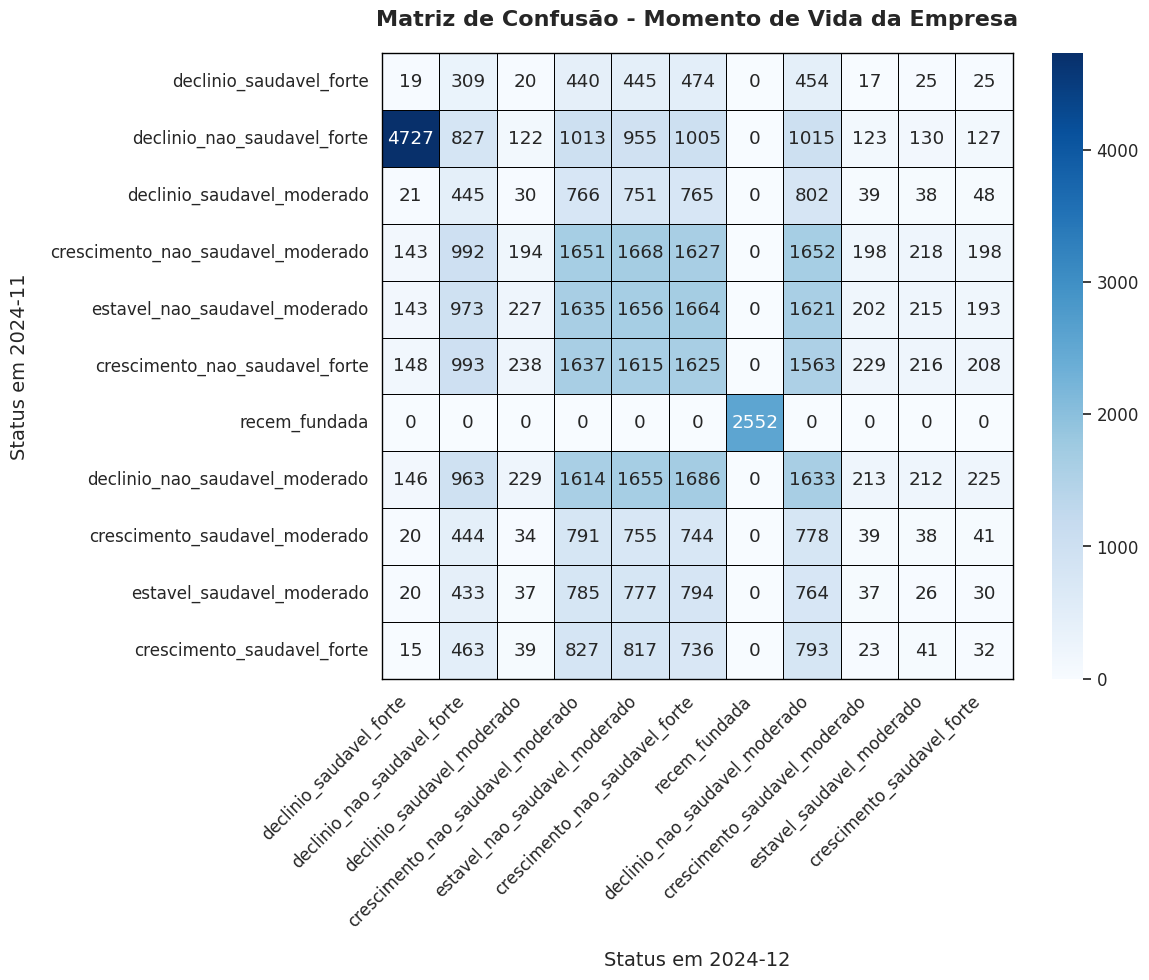

In [95]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Gerar a matriz de confusão
cm = confusion_matrix(y_true=y_202412, y_pred=y_202411, labels=labels)

# --- Visualização da Matriz de Confusão (Estilo Coorporativo) ---

plt.figure(figsize=(12, 10))  # Aumenta o tamanho da figura
sns.set(font_scale=1.1)  # Aumenta o tamanho da fonte para melhor legibilidade

# Cria o heatmap com Seaborn
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,  # Use 'd' para inteiros
                 xticklabels=labels, yticklabels=labels,
                 linewidths=.5, linecolor='black')  # Adiciona linhas entre as células

# Customização para apresentação coorporativa:

# Títulos e rótulos
plt.title('Matriz de Confusão - Momento de Vida da Empresa', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Status em 2024-12', fontsize=14, labelpad=15)
plt.ylabel('Status em 2024-11', fontsize=14, labelpad=15)

# Rotaciona os rótulos do eixo x para melhor legibilidade
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)

# Adiciona uma borda à figura
plt.tight_layout()
ax.spines[['top', 'right', 'bottom', 'left']].set_visible(True)
ax.spines[['top', 'right', 'bottom', 'left']].set_linewidth(1)
ax.spines[['top', 'right', 'bottom', 'left']].set_color('black')



# Mostra o gráfico
plt.show()

### 7.3. 202412 vs 202411 | Quantidade de CNPJs por Momento de Vida por segmento

In [145]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Função para carregar os dados
def load_data(data_str):
    return pd.read_csv(pd.StringIO(data_str))

# Leitura dos dados
df1 = df_classificados_202411
df2 = df_classificados_202412

# Atribuir um mês de referência para facilitar identificação
df1['mes_ref'] = '2024-11'
df2['mes_ref'] = '2024-12'

# Realizar a contagem de CNPJs por personas e status_momento_empresa
count_df1 = df1.groupby(['personas', 'status_momento_empresa']).size().reset_index(name='contagem')
count_df2 = df2.groupby(['personas', 'status_momento_empresa']).size().reset_index(name='contagem')

# Combinar contagens para ordenar de forma consistente
combined_counts = pd.concat([count_df1, count_df2])
total_by_status = combined_counts.groupby('status_momento_empresa')['contagem'].sum().reset_index()
status_order = total_by_status.sort_values('contagem', ascending=False)['status_momento_empresa'].tolist()

# Garantir que todas as categorias de status estejam em ambos os conjuntos de dados
all_status = list(set(count_df1['status_momento_empresa'].tolist() + count_df2['status_momento_empresa'].tolist()))
for status in all_status:
    if status not in count_df1['status_momento_empresa'].values:
        count_df1 = pd.concat([count_df1, pd.DataFrame({'personas': ['TOP'], 'status_momento_empresa': [status], 'contagem': [0]})])
    if status not in count_df2['status_momento_empresa'].values:
        count_df2 = pd.concat([count_df2, pd.DataFrame({'personas': ['TOP'], 'status_momento_empresa': [status], 'contagem': [0]})])

# Reordenar baseado na contagem total
count_df1['status_ordem'] = count_df1['status_momento_empresa'].apply(lambda x: status_order.index(x))
count_df2['status_ordem'] = count_df2['status_momento_empresa'].apply(lambda x: status_order.index(x))

count_df1 = count_df1.sort_values('status_ordem')
count_df2 = count_df2.sort_values('status_ordem')

# Definir uma paleta de cores para garantir consistência entre os gráficos
color_palette = {
    status: f'rgb({25+i*30}, {100+i*20}, {150+i*25})'
    for i, status in enumerate(status_order)
}

color_palette = {
    status: f'rgb({8+i*10}, {21+i*20}, {52+i*15})'
    for i, status in enumerate(status_order)
}

# color_palette = {
#     status: f'rgb({4+i*30}, {41+i*20}, {64+i*25})'
#     for i, status in enumerate(status_order)
# }

# Criar o layout de subplots (2 gráficos um em cima do outro)
fig = make_subplots(
    rows=2,
    cols=1,
    subplot_titles=("CNPJs por Status - Novembro 2024", "CNPJs por Status - Dezembro 2024"),
    vertical_spacing=0.15
)

# Adicionar barras para Novembro 2024 (primeiro subplot)
for status in status_order:
    df_status = count_df1[count_df1['status_momento_empresa'] == status]
    if not df_status.empty:
        fig.add_trace(
            go.Bar(
                x=df_status['personas'],
                y=df_status['contagem'],
                name=status.replace('_', ' ').title(),
                marker_color=color_palette[status],
                text=df_status['contagem'],
                textposition='auto'
            ),
            row=1, col=1
        )

# Adicionar barras para Dezembro 2024 (segundo subplot)
for status in status_order:
    df_status = count_df2[count_df2['status_momento_empresa'] == status]
    if not df_status.empty:
        fig.add_trace(
            go.Bar(
                x=df_status['personas'],
                y=df_status['contagem'],
                name=status.replace('_', ' ').title(),
                marker_color=color_palette[status],
                showlegend=False,  # Não mostrar na legenda para evitar duplicação
                text=df_status['contagem'],
                textposition='auto'
            ),
            row=2, col=1
        )

# Configurar layout do gráfico
fig.update_layout(
    title={
        # 'text': 'Distribuição de CNPJs por Status da Empresa',
        'text': '',
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': {'size': 22, 'color': '#333', 'family': 'Arial, sans-serif'}
    },
    barmode='group',  # Barras agrupadas, não empilhadas
    bargap=0.25,      # Espaço entre grupos de barras
    bargroupgap=0.1,  # Espaço entre barras no mesmo grupo
    legend={
        'title': 'Status da Empresa',
        'orientation': 'h',
        'yanchor': 'bottom',
        'y': 1.02,
        'xanchor': 'center',
        'x': 0.5,
        'font': {'size': 12}
    },
    height=800,
    width=1400,
    template='plotly_white',
    font={'family': 'Arial, sans-serif', 'color': '#333'}
)

# Configurar os eixos
fig.update_xaxes(title_text='Personas', row=1, col=1)
fig.update_xaxes(title_text='Personas', row=2, col=1)
fig.update_yaxes(title_text='Quantidade de CNPJs', row=1, col=1)
fig.update_yaxes(title_text='Quantidade de CNPJs', row=2, col=1)

# Ajustar o layout para formatação corporativa
fig.update_yaxes(gridcolor='lightgray', gridwidth=0.5)
fig.update_xaxes(showline=True, linecolor='lightgray', linewidth=1)
fig.update_yaxes(showline=True, linecolor='lightgray', linewidth=1)

# Mostrar o gráfico
fig.show()

### To Do:

* Coletar insights sobre os resultados atualizados:
  * O Momento geral do segmento é de queda? Faz sentido?
  * Temos mais empresas caindo ou crescendo? A mensagem corrobora com os dados?
  * Quantos CNPJs nós falamos que estão crescendo e inativaram/entraram em pendência
  * Quantos CNPJs nós falamos que estão crescendo e passaram a ser classificados  com declinio MoM (202412 e 202411): M0 (3M) vs M3 (3M)
  * Quantos CNPJs nós falamos que estão estável e inativaram/entraram em pendência
  * Quantos CNPJs nós falamos que estão estável e passaram a ser classificados  com declinio MoM (202412 e 202411): M0 (3M) vs M3 (3M)
  * Quantos CNPJs nós falamos que estão caindo e inativaram/entraram em pendência
  * Quantos CNPJs nós falamos que estão caindo e passaram a ser classificados  com crescimento MoM (202412 e 202411): M0 (3M) vs M3 (3M)